# Build an Augmented LLM with Tools in LangGraph

We already know Tools help the LLM interact with external sources of information like web search

Augmented LLM with Search Tool: Here we will build a simple augmented LLM using the capabilities of Tavily Search as a tool to allow the LLM to fetch relevant information from the web when necessary.

![](https://i.imgur.com/5r015dw.png)

In [1]:
!pip install langchain==0.3.14
!pip install langchain-openai==0.3.0
!pip install langchain-community==0.3.14
!pip install langgraph==0.2.64

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.0
    Uninstalling langsmith-0.3.0:
      Successfully uninstalled langsmith-0.3.0
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.15
    Uninstalling langchain-0.3.15:
      Successfully uninstalled langchain-0.3.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.6 MB/s eta 0:00:00


## Enter Open AI API Key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [3]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


## Setup Environment Variables

In [4]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

## Augment the LLM with tools

Here we define our custom search tool and then bind it to the LLM to augment the LLM

In [6]:
from langchain_openai import ChatOpenAI
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import tool

llm = ChatOpenAI(model="gpt-4o", temperature=0)

tavily_search = TavilySearchAPIWrapper()
@tool
def search_web(query: str, num_results=5):
    """Search the web for a query. Userful for general information or general news"""
    results = tavily_search.raw_results(query=query,
                                        max_results=num_results,
                                        search_depth='advanced',
                                        include_raw_content=True)
    return results

tools = [search_web]
llm_with_tools = llm.bind_tools(tools=tools)

In [7]:
llm_with_tools.invoke('what is AI in 1 line')

AIMessage(content='AI, or Artificial Intelligence, is the simulation of human intelligence processes by machines, especially computer systems, to perform tasks such as learning, reasoning, and problem-solving.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 72, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-59f80f35-cd93-4ea2-9c4e-a8e7d1a0e3b5-0', usage_metadata={'input_tokens': 72, 'output_tokens': 35, 'total_tokens': 107, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [8]:
llm_with_tools.invoke('what is the latest news on nvidia')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uk6ZSz8PaeTFpGx4Y0tLpe03', 'function': {'arguments': '{"query":"latest news on Nvidia","num_results":5}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 73, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7313fb62-7fd3-4117-9936-598cab119493-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'latest news on Nvidia', 'num_results': 5}, 'id': 'call_uk6ZSz8PaeTFpGx4Y0tLpe03', 'type': 'tool_call'}], usage_metadata={'input_tokens': 73, 'output_tokens': 23, 'total_tokens': 96, 'input_token_details': {'audio': 0, 'cache_rea

## Create the Graph with the Augmented LLM

![](https://i.imgur.com/5r015dw.png)

In [9]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Augmented LLM with Tools Node function
def tool_calling_llm(state: State) -> State:
    current_state = state["messages"]
    return {"messages": [llm_with_tools.invoke(current_state)]}

# Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools=tools))
builder.add_edge(START, "tool_calling_llm")

# Conditional Edge
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from LLM is a tool call -> tools_condition routes to tools
    # If the latest message (result) from LLM is a not a tool call -> tools_condition routes to END
    tools_condition,
    ["tools", END]
)
builder.add_edge("tools", END)
graph = builder.compile()

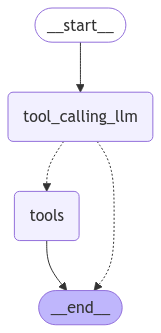

In [10]:
graph

In [11]:
user_input = "Explain AI in 2 bullets"
for event in graph.stream({"messages": user_input},
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Explain AI in 2 bullets
================================== Ai Message ==================================

- **Definition and Functionality**: Artificial Intelligence (AI) refers to the simulation of human intelligence processes by machines, especially computer systems. These processes include learning (the acquisition of information and rules for using the information), reasoning (using rules to reach approximate or definite conclusions), and self-correction.

- **Applications and Impact**: AI is utilized in various applications such as natural language processing, robotics, and computer vision, significantly impacting industries like healthcare, finance, and transportation by improving efficiency, accuracy, and decision-making capabilities.


In [12]:
user_input = "What is the latest news on OpenAI product releases"
for event in graph.stream({"messages": user_input},
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

What is the latest news on OpenAI product releases
================================== Ai Message ==================================
Tool Calls:
  search_web (call_XTOjdjVIw3t3hRGVT9e6yZ44)
 Call ID: call_XTOjdjVIw3t3hRGVT9e6yZ44
  Args:
    query: OpenAI latest product releases
    num_results: 5
================================= Tool Message =================================
Name: search_web

{"query": "OpenAI latest product releases", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "OpenAI teases 12 days of mystery product launches starting tomorrow", "url": "https://arstechnica.com/ai/2024/12/openai-teases-12-days-of-mystery-product-launches-starting-tomorrow/", "content": "OpenAI teases 12 days of mystery product launches starting tomorrow - Ars Technica OpenAI's \"12 days of shipmas\" will reveal new AI releases and demos for two weeks. On Wednesday, OpenAI CEO Sam Al